# Multiple variable linear regression

During this lecture the linear regression model seen before will be extended to support multiple features:

    - Extend data structures to support multiple features
    - Rewrite prediction, cost and gradient routines to support multiple features
    - Utilize NumPy `np.dot` to vectorize their implementations for speed and simplicity

In [1]:
import copy, math
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)  # reduced display precision on numpy arrays

## Problem statement

In this lab will still be used the example we were following before about the housing prices; this time the data set will contain examples with more features with respect with those we had before as they are showed in the tab below. 

| Size (sqft) | Number of Bedrooms  | Number of floors | Age of  Home | Price (1000s dollars)  |   
| ----------------| ------------------- |----------------- |--------------|-------------- |  
| 120            | 3                   | 1                | 20           | 350           |  
| 85            | 2                   | 2                | 10           | 220           |  
| 20             | 4                   | 1                | 5           | 540           |  
| 150 | 3 | 2 | 30 | 300 |
| 95 | 2 | 1 | 15 | 240 |

In [2]:
# Features: [Size (m²), Bedrooms, Floors, Age of Home (yrs)]
X_train = np.array([
    [120, 3, 1, 20],
    [85, 2, 2, 10],
    [200, 4, 1, 5],
    [150, 3, 2, 30],
    [95, 2, 1, 15]
])

# Target: Price in thousands of euros
y_train = np.array([350, 220, 540, 300, 240])


Similar to the table above, examples are stored in a NumPy matrix `X_train`. Each row of the matrix represents one example. When you have $m$ training examples ( $m$ is five in our example), and there are $n$ features (four in our example), $\mathbf{X}$ is a matrix with dimensions ($m$, $n$) (m rows, n columns).


$$\mathbf{X} = 
\begin{pmatrix}
 x^{(0)}_0 & x^{(0)}_1 & \cdots & x^{(0)}_{n-1} \\ 
 x^{(1)}_0 & x^{(1)}_1 & \cdots & x^{(1)}_{n-1} \\
 \cdots \\
 x^{(m-1)}_0 & x^{(m-1)}_1 & \cdots & x^{(m-1)}_{n-1} 
\end{pmatrix}
$$
notation:
- $\mathbf{x}^{(i)}$ is vector containing example i. $\mathbf{x}^{(i)}$ $ = (x^{(i)}_0, x^{(i)}_1, \cdots,x^{(i)}_{n-1})$
- $x^{(i)}_j$ is element j in example i. The superscript in parenthesis indicates the example number while the subscript represents an element.  

Display the input data.

In [3]:
# data is stored in numpy array/matrix
print(f"X Shape: {X_train.shape}, X Type:{type(X_train)})")
print(X_train)
print(f"y Shape: {y_train.shape}, y Type:{type(y_train)})")
print(y_train)

X Shape: (5, 4), X Type:<class 'numpy.ndarray'>)
[[120   3   1  20]
 [ 85   2   2  10]
 [200   4   1   5]
 [150   3   2  30]
 [ 95   2   1  15]]
y Shape: (5,), y Type:<class 'numpy.ndarray'>)
[350 220 540 300 240]


* $\mathbf{w}$ is a vector with $n$ elements.
  - Each element contains the parameter associated with one feature.
  - in our dataset, n is 4.
  - notionally, we draw this as a column vector

$$\mathbf{w} = \begin{pmatrix}
w_0 \\ 
w_1 \\
\cdots\\
w_{n-1}
\end{pmatrix}
$$
* $b$ is a scalar parameter.  

For demonstration, $\mathbf{w}$ and $b$ will be loaded with some initial selected values that are near the optimal. $\mathbf{w}$ is a 1-D NumPy vector.

In [15]:
# same features as before: [size, bedrooms, floors, age]
np.random.seed(42)  # just for reproducibility

w_init = np.random.randn(4) * 10  # random weights with moderate scale
b_init = np.random.randn() * 100   # random bias

print(f"w_init = {w_init}")
print(f"b_init = {b_init}")
print(f"w_init shape: {w_init.shape}, b_init type: {type(b_init)}")


w_init = [ 4.97 -1.38  6.48 15.23]
b_init = -23.415337472333597
w_init shape: (4,), b_init type: <class 'float'>


The model's prediction with multiple variables is given by the linear model:

$$ f_{\mathbf{w},b}(\mathbf{x}) =  w_0x_0 + w_1x_1 +... + w_{n-1}x_{n-1} + b \tag{1}$$
or in vector notation:
$$ f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b  \tag{2} $$ 
where $\cdot$ is a vector `dot product`

In [16]:
#lets define a predict function using np.dot routine from numpy library

def predict(x, w, b):
    """
    This function gets as parameters a set of features x, a set of weights for each feature and the bias term
    returns a prediction (scalar)
    """
    p = np.dot(w,x) + b
    return p

In [17]:
#to test the function just defined we can start by picking a row of our dataset
x_vector_0 = X_train[0,:]

print(f"printing out the first row of the data set just defined {x_vector_0}")


x_vector_3 = X_train[3, :]
print(f"printing out the third row of the data just defined {x_vector_3}")

print(f"The shape of the two vectors just defined is {x_vector_0.shape} and {x_vector_3.shape}")


printing out the first row of the data set just defined [120   3   1  20]
printing out the third row of the data just defined [150   3   2  30]
The shape of the two vectors just defined is (4,) and (4,)


In [18]:
#now to make a prediction using the function we just defined we can do
f_wb = predict(x_vector_0, w_init, b_init)

print(f"The shape of f_wb is {f_wb.shape} and its values is {f_wb}")

The shape of f_wb is () and its values is 879.5765737686221


The equation for the cost function with multiple variables $J(\mathbf{w},b)$ is:
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 \tag{3}$$ 
where:
$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b  \tag{4} $$ 


In contrast to previous labs, $\mathbf{w}$ and $\mathbf{x}^{(i)}$ are vectors rather than scalars supporting multiple features.

In [26]:
def compute_cost(X, y, w, b):
    """
    X is the dataset containing m samples of n features with shape (m, n)
    w is the set of weights and has shape (n,)
    b is the bias parameters
    y are the target values with shape (m,)
    The function returns a (scalar) cost
    """

    m = X.shape[0] #initializing m as the number of rows in our dataset (each row represents a set of data)
    cost = 0.0
    for i in range(m): #so that we can iterate over the number of samples passed to it
        f_wb_i = np.dot(X[i], w) + b
        cost = cost + (f_wb_i - y[i])**2
    total_cost = cost/(2*m)
    return total_cost

In [27]:
# Compute and display cost using our pre-chosen optimal parameters. 
cost = compute_cost(X_train, y_train, w_init, b_init)
print(f'Cost at optimal w : {cost}')

Cost at optimal w : 163566.77046299152


It has to be noted that $\vec{w}$, altough it is a vector, doesn't need to be indexed like the training example $\vec{X[i]}$ does; this comes from the fact that $\vec{w}$ is a set of values corresponding to each *feature* specifically whereas the $\vec{X[i]}$ identifies a specific row of our dataset instead. So in the loop we don't need to index $\vec{w}$ and the np.dot function automatically associates each value for that row we selected ($\vec{X[i]}$) with the values inside the weight vector $\vec{w}$.

Gradient descent for multiple variables:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{5}  \; & \text{for j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

where, n is the number of features, parameters $w_j$,  $b$, are updated simultaneously and where  

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{6}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{7}
\end{align}
$$
* m is the number of training examples in the data set

    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value


An implementation for calculating the equations (6) and (7) is below. There are many ways to implement this. In this version, there is an
- outer loop over all m examples. 
    - $\frac{\partial J(\mathbf{w},b)}{\partial b}$ for the example can be computed directly and accumulated
    - in a second loop over all n features:
        - $\frac{\partial J(\mathbf{w},b)}{\partial w_j}$ is computed for each $w_j$.

In [43]:
def compute_gradient(X, y, w, b):
    """
    X array with m examples and n features (our matrix m rows by n columns)
    y array of target values m (one for each sample in our dataset)
    w array of weights for each feature so has size n
    b bias term
    The function returns:
    dj_dw which has the same dimensions of w (n, )
    dj_db which is a scalar 
    """
    m, n = X.shape 
    #this time we dont have to specify X[0] to state that we are referring to a single column
    #in this way we are able to specify that m has to cover the first dimension of our data set: m the number of samples
    #and n will cover the second dimension of our dataset X which belongs to the number of features
    dj_dw = np.zeros((n, ))
    dj_db = 0.
    for i in range(m):
        deviation = (np.dot(X[i], w) + b) - y[i] #loop over each sample
        for j in range(n): #loop over each feature
            dj_dw[j] = dj_dw[j] + deviation*X[i, j]
        dj_db = dj_db + deviation
    dj_dw = dj_dw/m
    dj_db = dj_db/m
    return dj_dw, dj_db

In [44]:
#Compute and display gradient 
tmp_dj_db, tmp_dj_dw = compute_gradient(X_train, y_train, w_init, b_init)
print(f'dj_db at initial w,b: {tmp_dj_db}')
print(f'dj_dw at initial w,b: \n {tmp_dj_dw}')

dj_db at initial w,b: [73789.16  1568.62   786.92  9954.1 ]
dj_dw at initial w,b: 
 541.1940775681694


In [45]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iterations):
    """
    Performs batch gradient descent to estimate w and b
    w and b are updated a number of iterations equal to num_iterations with learning rate alpha
    X is the set of data with m samples of n features
    y is an array of dimensions (m, ) of target values
    w_in is an array of dimensions (n, ) of initial model parameters
    b_in is a scalar bias model parameter
    gradient_function is the function to compute the gradient (we just defined compute_gradient)
    alpha is a paramteter called the learning rate alpha
    num_iterations is the number of iterations to run the gradient descent
    This function returns updated values for both w and b
    """
    J_history = [] #we initialize an array to store the values of J at each iteration to display them later
    w = copy.deepcopy(w_in) #to avoid modifying the global w within the function
    b = b_in

    for i in range(num_iterations):
        dj_dw, dj_db = compute_gradient(X, y, w, b)
        #update parameters
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        if i<100000:
            J_history.append(cost_function(X, y, w, b))
        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iterations / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}   ")
        
    return w, b, J_history #return final w,b and J history for graphing

In [47]:
# initialize parameters
initial_w = np.zeros_like(w_init)
initial_b = 0.
# some gradient descent settings
iterations = 1000
alpha = 1.0e-6
# run gradient descent 
w_final, b_final, J_hist = gradient_descent(X_train, y_train, initial_w, initial_b,
                                                    compute_cost, compute_gradient, 
                                                    alpha, iterations)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
m,_ = X_train.shape
for i in range(m):
    print(f"prediction: {np.dot(X_train[i], w_final) + b_final:0.2f}, target value: {y_train[i]}")

Iteration    0: Cost 58768.73   
Iteration  100: Cost  2313.47   
Iteration  200: Cost  1053.51   
Iteration  300: Cost  1017.49   
Iteration  400: Cost  1008.79   
Iteration  500: Cost  1000.85   
Iteration  600: Cost   993.09   
Iteration  700: Cost   985.50   
Iteration  800: Cost   978.07   
Iteration  900: Cost   970.80   
b,w found by gradient descent: 0.02,[ 2.54  0.06  0.01 -0.  ] 
prediction: 304.49, target value: 350
prediction: 215.70, target value: 220
prediction: 507.49, target value: 540
prediction: 380.56, target value: 300
prediction: 241.04, target value: 240


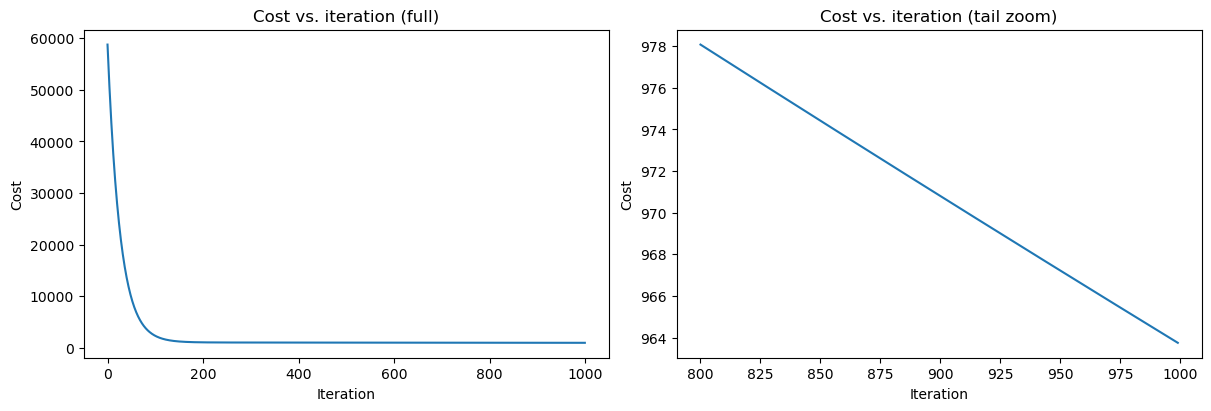

In [52]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))

# full curve
ax1.plot(J_hist)
ax1.set_title("Cost vs. iteration (full)")
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Cost')

# tail curve — zoom in on last 20% of iterations
tail_start = int(len(J_hist) * 0.8)
ax2.plot(np.arange(tail_start, len(J_hist)), J_hist[tail_start:])
ax2.set_title("Cost vs. iteration (tail zoom)")
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Cost')

plt.show()